In [1]:
# Let's pip install effcientnet lib 
%pip install efficientnet
%pip install matplotlib
%pip install pillow
%pip install seaborn
%pip install plotly
%pip install tensorflow
%pip install tqdm


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note

In [2]:
# Import all the libraries 
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import shutil
from PIL import Image, ImageOps  
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
import plotly.io as pio
pio.templates.default = 'plotly_white'
init_notebook_mode(connected=True)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPooling2D
from  tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import metrics
import efficientnet.tfkeras as efn
from tqdm import tqdm_notebook

In [3]:
# Some global variable
master_path = 'path_to_data_folder'

In [4]:
summary = pd.read_csv(f'{master_path}/input/Chest_xray_Corona_dataset_Summary.csv')
df = pd.read_csv(f'{master_path}/input/Chest_xray_Corona_Metadata.csv')
print(df.head())

#create dummy variable
replace_dict = {'Pnemonia':1,
                'Normal':0}
# replace Pnemonia as 1 and Normal as 0
df['Label'] = df['Label'].replace(replace_dict)

# split df into train_df, test_df by Dataset_type field
train_df = df[df.Dataset_type=='TRAIN']
print(train_df.head())
test_df = df[df.Dataset_type=='TEST']
print(test_df.head())

   Unnamed: 0   X_ray_image_name   Label Dataset_type Label_2_Virus_category  \
0           0  IM-0128-0001.jpeg  Normal        TRAIN                    NaN   
1           1  IM-0127-0001.jpeg  Normal        TRAIN                    NaN   
2           2  IM-0125-0001.jpeg  Normal        TRAIN                    NaN   
3           3  IM-0122-0001.jpeg  Normal        TRAIN                    NaN   
4           4  IM-0119-0001.jpeg  Normal        TRAIN                    NaN   

  Label_1_Virus_category  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  
   Unnamed: 0   X_ray_image_name  Label Dataset_type Label_2_Virus_category  \
0           0  IM-0128-0001.jpeg      0        TRAIN                    NaN   
1           1  IM-0127-0001.jpeg      0        TRAIN                    NaN   
2           2  IM-0125-0001.jpeg      0        TRAIN                    NaN   
3           3  IM-0122-0001.jpeg      0  

/var/folders/qy/63n4c2vx1mndmjlfl6ld1ntw0000gn/T/ipykernel_2328/330789092.py:9: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [5]:
# Tạo Pie chart với giá trị là tỷ lệ của mỗi category
colors = ['gold', 'blue']

fig = go.Figure(
    data=[go.Pie(labels=['Pneumonia', 'Normal'], # Add Lable
    values=[df.Label.value_counts()[1], df.Label.value_counts()[0]])], # Add values
)

fig.update_traces(
    textinfo='percent+label', # add lable in chart
    textfont_size=20, # add text font size
    marker=dict(colors=colors,line=dict(color='#000000',width=2)), # add chart corlor and line corlor. width
)
fig.update_layout(title_text='Distributions of classes in the data', font_size=20) # add chart header
fig.show()

In [6]:
# Defining the path to Train and Test directories
training_data_path = f'{master_path}/input/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
testing_data_path = f'{master_path}/input/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'


In [7]:
# Funtions for Making and Removing subdirectories
def create_dir():
    try:
        os.makedirs(f'{master_path}/working/train/Pneumonia')
        os.makedirs(f'{master_path}/working/train/Normal')
        os.makedirs(f'{master_path}/working/test/Pneumonia')
        os.makedirs(f'{master_path}/working/test/Normal')
    except:
        pass
def remove_dir():
    try:
        shutil.rmtree(f'{master_path}/working/train')
        shutil.rmtree(f'{master_path}/working/test')    
    except:
        pass

In [8]:
# Seperate dataframes for different labels in test and train
train_pneumonia_df = train_df[train_df.Label==1]
train_normal_df = train_df[train_df.Label==0]
test_pneumonia_df = test_df[test_df.Label==1]
test_normal_df = test_df[test_df.Label==0]

In [9]:
# Copying the files to newly created locations. You may use Flow from dataframe attribute and skip all these steps. But I prefer to use flow from directory 
remove_dir()
create_dir()

training_images_pneumonia = train_pneumonia_df.X_ray_image_name.values.tolist()
training_images_normal = train_normal_df.X_ray_image_name.values.tolist()
testing_images_pneumonia = test_pneumonia_df.X_ray_image_name.values.tolist()
testing_images_normal = test_normal_df.X_ray_image_name.values.tolist()

for image in training_images_pneumonia:
    train_image_pneumonia = os.path.join(training_data_path, str(image))  # get pneumonia image path
    shutil.copy(train_image_pneumonia, f'{master_path}/working/train/Pneumonia')  # copy pneumonia image to the destination
    
for image in training_images_normal:
    train_image_normal = os.path.join(training_data_path, str(image))
    shutil.copy(train_image_normal, f'{master_path}/working/train/Normal')
    
for image in testing_images_pneumonia:
    test_image_pneumonia = os.path.join(testing_data_path, str(image))
    shutil.copy(test_image_pneumonia, f'{master_path}/working/test/Pneumonia')
    
for image in testing_images_normal:
    test_image_normal = os.path.join(testing_data_path, str(image))
    shutil.copy(test_image_normal, f'{master_path}/working/test/Normal')

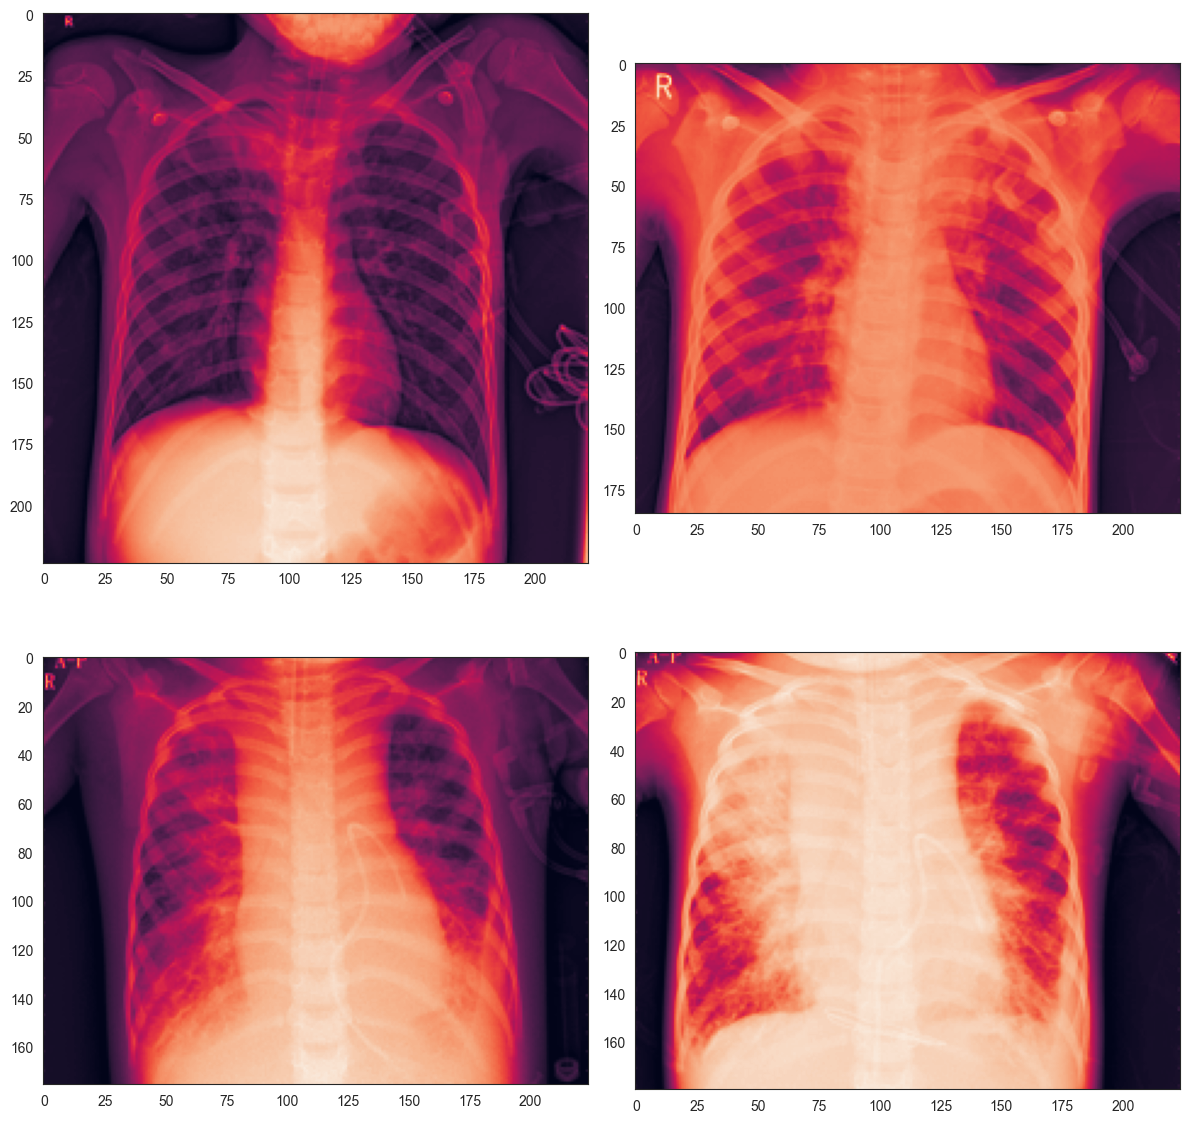

In [10]:
# VisualaiCzing the Pneumonia affected Xrays
plt.figure(figsize=(12,12)) # This line sets the size of the figure to 12x12 inches. This will be the canvas on which the images will be displayed.

for index, fn in enumerate(training_images_pneumonia[:4]): # This loop iterates over the first four filenames in the training_images_pneumonia list. The enumerate function is used to get both the index and the filename (fn).
    path = f'{master_path}/working/train/Pneumonia/' + str(fn) # file path
    image = Image.open(path) # open image from path above
    image = ImageOps.grayscale(image) #This converts the image to grayscale
    image.thumbnail((224,224)) # This resizes the image to fit within a 224x224 pixel box while maintaining the aspect ratio
    plt.subplot(2,2,index+1) # creates a 2x2 grid of subplots and put the current image in the index+1th subplot.
    plt.imshow(image) # displays the current image in the selected subplot

plt.tight_layout() # adjusts the spacing between subplots to minimize overlap and ensure the layout is clean

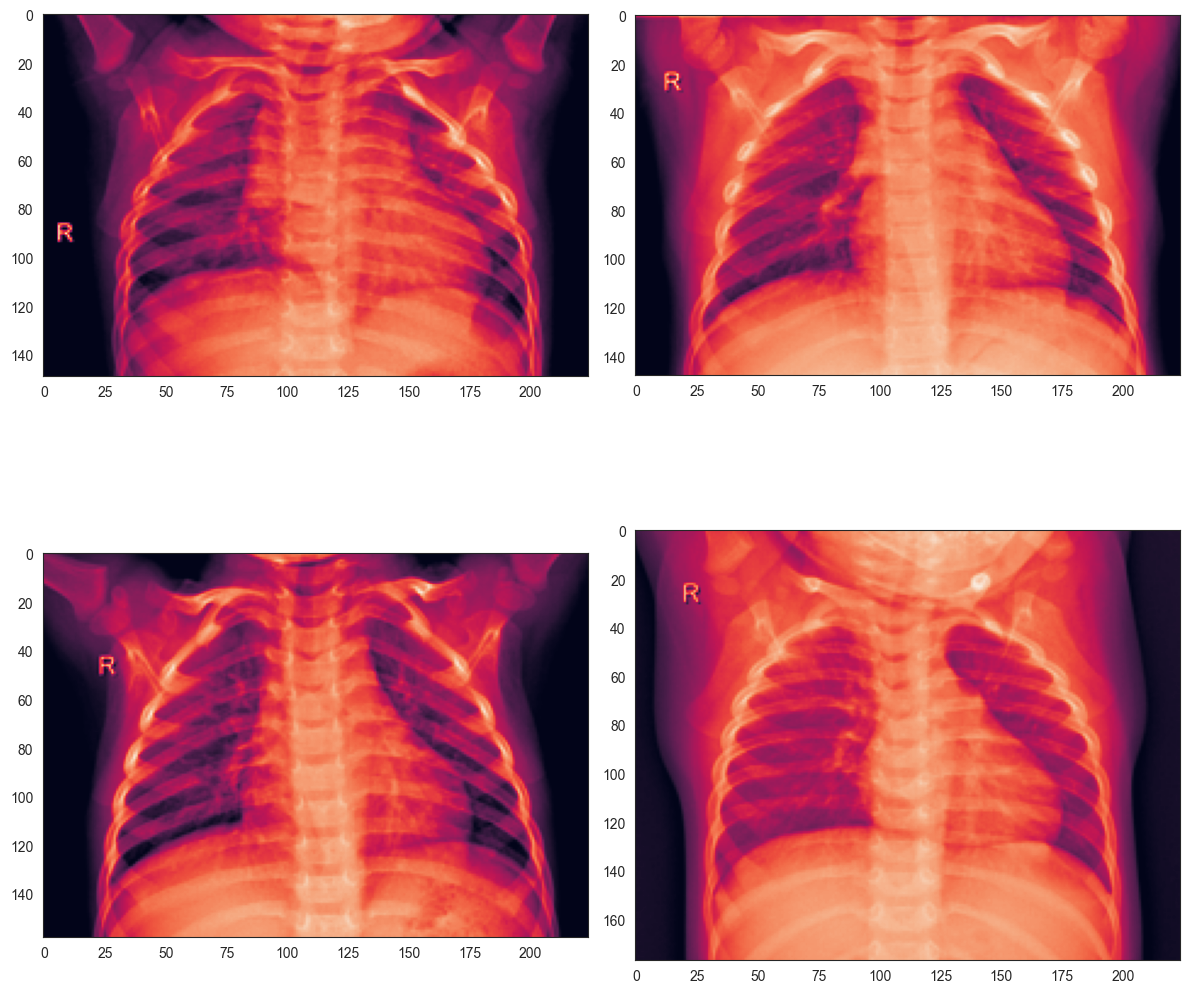

In [11]:
# VisualaiCzing the Normal  Xrays
plt.figure(figsize=(12,12))
for index, fn in enumerate(training_images_normal[:4]):
    path = f'{master_path}/working/train/Normal/' + str(fn)
    image = Image.open(path)
    image = ImageOps.grayscale(image)
    image.thumbnail((224,224))
    plt.subplot(2,2,index+1)
    plt.imshow(image)

plt.tight_layout()

In [12]:
# Model configuration
batch_size = 64
img_width, img_height, img_num_channels = 224,224,3
no_epochs = 15
verbosity = 1
input_shape = (img_width, img_height, img_num_channels)

In [13]:
#Creating an EffNet model
model_B7 = efn.EfficientNetB7(weights='imagenet', input_shape=input_shape, include_top=False)

In [14]:
# Function to build, compile and train the model

# Tạo ra một bộ sinh dữ liệu hình ảnh với nhiều phương pháp tăng cường dữ liệu khác nhau để áp dụng cho dữ liệu huấn luyện
train_datagen = ImageDataGenerator(
    rescale=1./255, # Chuẩn hóa giá trị điểm ảnh về khoảng [0, 1]
    shear_range=0.2, # Áp dụng biến đổi cắt xén ngẫu nhiên.
    rotation_range=0.2, # Áp dụng xoay ngẫu nhiên.
    width_shift_range=0.2, # Dịch chuyển ngẫu nhiên hình ảnh theo chiều ngang .
    height_shift_range=0.2, # Dịch chuyển ngẫu nhiên hình ảnh theo chiều dọc.
    zoom_range=0.2, # Thu phóng ngẫu nhiên từ 0 - 0.2 Radian
    horizontal_flip=True, # Lật ngẫu nhiên hình ảnh theo chiều ngang
    vertical_flip=True, # lật ngãu nhiên hình ảnh theo chiều dọc
    fill_mode='nearest', # Định dạng cách lấp đầy các điểm ảnh mới tạo ra bằng mode "nearest"
)
# Tạo các dữ liệu, tăng cường từ thư mục huấn luyện.
train_generator = train_datagen.flow_from_directory(
    f'{master_path}/working/train',
    target_size=(224,224), # Thay đổi kích thước hình ảnh về 224x224 pixel.
    batch_size=batch_size, #  Định nghĩa số lượng hình ảnh trong mỗi lô.
    class_mode='binary', # Chỉ định các nhãn dạng nhị phân cho dữ liệu.
)

# Tạo các lô dữ liệu kiểm tra mà không áp dụng các phương pháp tăng cường.
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory(f'{master_path}/working/test',
                                                    target_size=(224,224),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

# Cấu hình các lớp của mô hình tiền huấn luyện EfficientNetB7 để tinh chỉnh.
pretrained_model = model_B7
pretrained_model.trainable=True # Đặt toàn bộ mô hình tiền huấn luyện có thể huấn luyện được.
set_trainable=False

for layer in pretrained_model.layers:
    # các lớp trước 'block7c_project_conv' không thể huấn luyện và các lớp từ 'block7c_project_conv' trở đi có thể huấn luyện.
    if layer.name == 'block7c_project_conv':
        set_trainable=True
    if set_trainable:
        layer.trainable=True
    else:
        layer.trainable=False


# Xây dựng mô hình tuần tự bằng cách thêm các lớp.
model=Sequential()
model.add(pretrained_model)
model.add(MaxPooling2D(name="MaxPool_"))
model.add(Dropout(0.2, name="dropout_out"))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# Cấu hình mô hình để huấn luyện.
model.compile(
    loss=binary_crossentropy,  # Sử dụng hàm mất mát binary cross-entropy
    optimizer=Adam(), # Sử dụng trình tối ưu hóa Adam.
    metrics=[metrics.AUC(name='auc'), 'accuracy'], # Giám sát AUC và độ chính xác trong quá trình huấn luyện.
)

# Thiết lập một callback để dừng sớm quá trình huấn luyện khi AUC của dữ liệu kiểm tra không cải thiện.
es_callback = EarlyStopping(
    monitor='val_auc', # Giám sát AUC của dữ liệu kiểm tra.
    mode='max', # Dừng khi AUC đạt giá trị tối đa.
    patience=8, # Chờ 8 epoch nếu không có cải thiện trước khi dừng.
    verbose=1,
    min_delta=0.0001,
    restore_best_weights=True, #  Khôi phục trọng số mô hình từ epoch có AUC kiểm tra tốt nhất.
)

# Huấn luyện mô hình sử dụng các bộ sinh dữ liệu huấn luyện và kiểm tra.
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples//batch_size,  # Số bước mỗi epoch
    epochs = no_epochs, # Số lượng epoch để huấn luyện
    validation_data=valid_generator, # Bộ dữ liệu kiểm tra
    validation_steps=valid_generator.samples//batch_size, # Số bước kiểm tra mỗi epoch.
    callbacks= [es_callback], # Sử dụng callback dừng sớm
    verbose=verbosity, # Thiết lập chế độ chi tiết (hiển thị thông tin trong quá trình huấn luyện).
)

Found 5286 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/15


/Users/huyentrangnguyen/anaconda3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



82/82 ━━━━━━━━━━━━━━━━━━━━ 830s 10s/step - accuracy: 0.8187 - auc: 0.8409 - loss: 0.5409 - val_accuracy: 0.8663 - val_auc: 0.9457 - val_loss: 0.3102
Epoch 2/15
 1/82 ━━━━━━━━━━━━━━━━━━━━ 6:59 5s/step - accuracy: 0.9062 - auc: 0.9535 - loss: 0.2547

2024-07-19 22:12:55.668109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/huyentrangnguyen/anaconda3/lib/python3.10/contextlib.py:153: UserWarning:

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.

2024-07-19 22:12:59.201490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.9062 - auc: 0.9535 - loss: 0.2547 - val_accuracy: 0.9583 - val_auc: 0.9963 - val_loss: 0.1493
Epoch 3/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 482s 6s/step - accuracy: 0.8906 - auc: 0.9488 - loss: 0.2640 - val_accuracy: 0.8802 - val_auc: 0.9468 - val_loss: 0.3225
Epoch 4/15
 1/82 ━━━━━━━━━━━━━━━━━━━━ 7:33 6s/step - accuracy: 0.8906 - auc: 0.9834 - loss: 0.2013

2024-07-19 22:21:07.343011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - accuracy: 0.8906 - auc: 0.9834 - loss: 0.2013 - val_accuracy: 0.8125 - val_auc: 0.9074 - val_loss: 0.4419
Epoch 5/15


2024-07-19 22:21:11.154907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 577s 7s/step - accuracy: 0.9116 - auc: 0.9563 - loss: 0.2360 - val_accuracy: 0.8767 - val_auc: 0.9280 - val_loss: 0.3218
Epoch 6/15
 1/82 ━━━━━━━━━━━━━━━━━━━━ 7:02 5s/step - accuracy: 0.8906 - auc: 0.9351 - loss: 0.2898

2024-07-19 22:30:53.183516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8906 - auc: 0.9351 - loss: 0.2898 - val_accuracy: 0.8125 - val_auc: 0.8830 - val_loss: 0.5024
Epoch 7/15


2024-07-19 22:30:56.706925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 482s 6s/step - accuracy: 0.9199 - auc: 0.9632 - loss: 0.2127 - val_accuracy: 0.8351 - val_auc: 0.9459 - val_loss: 0.4902
Epoch 8/15
 1/82 ━━━━━━━━━━━━━━━━━━━━ 7:04 5s/step - accuracy: 0.8750 - auc: 0.9754 - loss: 0.2878

2024-07-19 22:39:04.336313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 43ms/step - accuracy: 0.8750 - auc: 0.9754 - loss: 0.2878 - val_accuracy: 0.9583 - val_auc: 0.9513 - val_loss: 0.1910
Epoch 9/15


2024-07-19 22:39:07.801857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 481s 6s/step - accuracy: 0.9180 - auc: 0.9670 - loss: 0.2012 - val_accuracy: 0.7778 - val_auc: 0.8938 - val_loss: 0.8516
Epoch 10/15
 1/82 ━━━━━━━━━━━━━━━━━━━━ 6:56 5s/step - accuracy: 0.9062 - auc: 0.9479 - loss: 0.2617

2024-07-19 22:47:14.102428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - accuracy: 0.9062 - auc: 0.9479 - loss: 0.2617 - val_accuracy: 0.8542 - val_auc: 0.8778 - val_loss: 0.7691
Epoch 10: early stopping
Restoring model weights from the end of the best epoch: 2.


2024-07-19 22:47:17.744648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [15]:
# Tương tự như trên với model VGG16
from tensorflow.keras.applications import VGG16
vgg16 = VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=(img_width, img_height, img_num_channels))

for layer in vgg16.layers:
  layer.trainable = False

model1=Sequential()
model1.add(vgg16)
model1.add(MaxPooling2D(name="MaxPool_"))
model1.add(Dropout(0.2, name="dropout_out"))
model1.add(Flatten())
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss=binary_crossentropy,
              optimizer=Adam(),
              metrics=[metrics.AUC(name='auc'), 'accuracy'])

es_callback1 = EarlyStopping(monitor='val_auc', mode='max', patience=8,
                                              verbose=1, min_delta=0.0001, restore_best_weights=True)

history1 = model1.fit(train_generator,
                    steps_per_epoch=train_generator.samples//batch_size,
                    epochs = no_epochs,
                    validation_data=valid_generator,
                    validation_steps=valid_generator.samples//batch_size,
                    callbacks= [es_callback1],
                    verbose=verbosity)

Epoch 1/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 575s 7s/step - accuracy: 0.7238 - auc: 0.6728 - loss: 0.5750 - val_accuracy: 0.8542 - val_auc: 0.9295 - val_loss: 0.3626
Epoch 2/15
 1/82 ━━━━━━━━━━━━━━━━━━━━ 8:15 6s/step - accuracy: 0.8594 - auc: 0.9450 - loss: 0.3039

2024-07-19 22:57:00.312295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.8594 - auc: 0.9450 - loss: 0.3039 - val_accuracy: 0.7500 - val_auc: 0.8866 - val_loss: 0.4610
Epoch 3/15


2024-07-19 22:57:05.021074: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 573s 7s/step - accuracy: 0.8759 - auc: 0.9399 - loss: 0.2747 - val_accuracy: 0.8733 - val_auc: 0.9438 - val_loss: 0.3184
Epoch 4/15
 1/82 ━━━━━━━━━━━━━━━━━━━━ 8:11 6s/step - accuracy: 0.8750 - auc: 0.9447 - loss: 0.2696

2024-07-19 23:06:43.984912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.8750 - auc: 0.9447 - loss: 0.2696 - val_accuracy: 0.8958 - val_auc: 0.9293 - val_loss: 0.3092
Epoch 5/15


2024-07-19 23:06:48.689228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 578s 7s/step - accuracy: 0.9039 - auc: 0.9597 - loss: 0.2310 - val_accuracy: 0.8802 - val_auc: 0.9516 - val_loss: 0.2918
Epoch 6/15
 1/82 ━━━━━━━━━━━━━━━━━━━━ 8:16 6s/step - accuracy: 0.9062 - auc: 0.9518 - loss: 0.2319

2024-07-19 23:16:33.291753: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9062 - auc: 0.9518 - loss: 0.2319 - val_accuracy: 0.8333 - val_auc: 0.9101 - val_loss: 0.3555
Epoch 7/15


2024-07-19 23:16:38.069737: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 575s 7s/step - accuracy: 0.9101 - auc: 0.9639 - loss: 0.2168 - val_accuracy: 0.8906 - val_auc: 0.9562 - val_loss: 0.2770
Epoch 8/15
 1/82 ━━━━━━━━━━━━━━━━━━━━ 8:13 6s/step - accuracy: 0.9062 - auc: 0.9778 - loss: 0.2147

2024-07-19 23:26:19.657410: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9062 - auc: 0.9778 - loss: 0.2147 - val_accuracy: 0.8333 - val_auc: 0.9301 - val_loss: 0.3613
Epoch 9/15


2024-07-19 23:26:24.403281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 574s 7s/step - accuracy: 0.9221 - auc: 0.9712 - loss: 0.1938 - val_accuracy: 0.8733 - val_auc: 0.9539 - val_loss: 0.2958
Epoch 10/15
 1/82 ━━━━━━━━━━━━━━━━━━━━ 8:19 6s/step - accuracy: 0.8906 - auc: 0.9686 - loss: 0.2187

2024-07-19 23:36:04.597593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.8906 - auc: 0.9686 - loss: 0.2187 - val_accuracy: 0.8750 - val_auc: 0.9768 - val_loss: 0.2792
Epoch 11/15


2024-07-19 23:36:09.316331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 605s 7s/step - accuracy: 0.9178 - auc: 0.9674 - loss: 0.2001 - val_accuracy: 0.9097 - val_auc: 0.9561 - val_loss: 0.2665
Epoch 12/15
 1/82 ━━━━━━━━━━━━━━━━━━━━ 8:46 7s/step - accuracy: 0.8750 - auc: 0.9372 - loss: 0.3035

2024-07-19 23:46:20.773090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.8750 - auc: 0.9372 - loss: 0.3035 - val_accuracy: 0.8958 - val_auc: 0.9546 - val_loss: 0.3204
Epoch 13/15


2024-07-19 23:46:25.557528: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 588s 7s/step - accuracy: 0.9232 - auc: 0.9744 - loss: 0.1848 - val_accuracy: 0.9062 - val_auc: 0.9618 - val_loss: 0.2489
Epoch 14/15
 1/82 ━━━━━━━━━━━━━━━━━━━━ 8:31 6s/step - accuracy: 0.9219 - auc: 0.9556 - loss: 0.2040

2024-07-19 23:56:19.724336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9219 - auc: 0.9556 - loss: 0.2040 - val_accuracy: 0.9167 - val_auc: 0.9538 - val_loss: 0.2567
Epoch 15/15


2024-07-19 23:56:24.410788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


82/82 ━━━━━━━━━━━━━━━━━━━━ 577s 7s/step - accuracy: 0.9320 - auc: 0.9763 - loss: 0.1760 - val_accuracy: 0.9062 - val_auc: 0.9650 - val_loss: 0.2391
Restoring model weights from the end of the best epoch: 10.


In [16]:
#Plotting the evaluation metrics
# vẽ các biểu đồ đường (line plots) hiển thị các chỉ số đánh giá hiệu quả của mô hình EfficientNetB7 trong suốt quá trình huấn luyện
fig = go.Figure() # Khởi tạo một đối tượng Figure của Plotly, là nơi sẽ chứa các biểu đồ

#Thêm các đường biểu diễn giá trị AUC (Area Under Curve), accuracy và validation AUC, validation accuracy theo từng epoch
fig.add_trace(
    go.Scatter(
        x=list(range(1,12)),
        y=history.history['auc'],
        line=dict(color='firebrick',width=2, dash='dash'),
        name='AUC',
    )
) 
fig.add_trace(
    go.Scatter(
        x=list(range(1,12)),
        y=history.history['val_auc'],
        line=dict(color='turquoise', width=2),
        name='validation AUC',
    )
)

fig.add_trace(
    go.Scatter(
        x=list(range(1,12)),
        y=history.history['accuracy'],
        line=dict(color='orange', width=2, dash='dash'),
        name='accuracy',
    )
)
fig.add_trace(
    go.Scatter(
        x=list(range(1,12)),
        y=history.history['val_accuracy'],
        line=dict(color='green', width=2),
        name='validation accuracy',
    )
)

fig.update_layout(title_text='Plot of evaluation metrics', font_size=15, xaxis_title='Epochs') # Thêm title và title font size
fig.show()

In [17]:
# Xem giá trị cụ thể theo tùng epochs
final_results =  pd.DataFrame.from_dict(history.history)
print(final_results)

   accuracy       auc      loss  val_accuracy   val_auc  val_loss
0  0.866335  0.903479  0.386755      0.866319  0.945743  0.310215
1  0.906250  0.953488  0.254731      0.958333  0.996296  0.149323
2  0.901953  0.952985  0.245214      0.880208  0.946847  0.322476
3  0.890625  0.983389  0.201257      0.812500  0.907441  0.441939
4  0.908273  0.956157  0.237510      0.876736  0.928015  0.321785
5  0.890625  0.935143  0.289793      0.812500  0.883036  0.502358
6  0.918231  0.962426  0.220351      0.835069  0.945852  0.490195
7  0.875000  0.975439  0.287763      0.958333  0.951316  0.190952
8  0.923975  0.969764  0.192652      0.777778  0.893756  0.851575
9  0.906250  0.947917  0.261730      0.854167  0.877778  0.769077


In [18]:
#Plotting the evaluation metrics
# vẽ các biểu đồ đường (line plots) hiển thị các chỉ số đánh giá hiệu quả của mô hình VGG16 trong suốt quá trình huấn luyện
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1,12)), y=history1.history['auc'],
                         line=dict(color='firebrick', width=2, dash='dash'), name='AUC'))
fig.add_trace(go.Scatter(x=list(range(1,12)), y=history1.history['val_auc'],
                         line=dict(color='turquoise', width=2), name='validation AUC'))

fig.add_trace(go.Scatter(x=list(range(1,12)), y=history1.history['accuracy'],
                         line=dict(color='orange', width=2, dash='dash'), name='accuracy'))
fig.add_trace(go.Scatter(x=list(range(1,12)), y=history1.history['val_accuracy'],
                         line=dict(color='green', width=2), name='validation accuracy'))

fig.update_layout(title_text='Plot of evaluation metrics', font_size=15, xaxis_title='Epochs')
fig.show()

In [19]:
final_results =  pd.DataFrame.from_dict(history1.history)
print(final_results)

    accuracy       auc      loss  val_accuracy   val_auc  val_loss
0   0.803524  0.827074  0.428547      0.854167  0.929493  0.362589
1   0.859375  0.945029  0.303899      0.750000  0.886607  0.461015
2   0.887591  0.950902  0.256463      0.873264  0.943754  0.318394
3   0.875000  0.944661  0.269592      0.895833  0.929293  0.309181
4   0.901762  0.958617  0.232007      0.880208  0.951556  0.291797
5   0.906250  0.951815  0.231944      0.833333  0.910101  0.355500
6   0.914975  0.966901  0.208995      0.890625  0.956232  0.277024
7   0.906250  0.977778  0.214728      0.833333  0.930070  0.361286
8   0.923784  0.970160  0.195654      0.873264  0.953865  0.295844
9   0.890625  0.968599  0.218738      0.875000  0.976786  0.279198
10  0.922252  0.971186  0.188589      0.909722  0.956136  0.266500
11  0.875000  0.937229  0.303475      0.895833  0.954628  0.320422
12  0.925316  0.973615  0.182833      0.906250  0.961753  0.248864
13  0.921875  0.955556  0.203951      0.916667  0.953782  0.25